
### **Chapter 5: Model Predictive Control**

???

1) cost: one norm, etc.

2) open-loop -> etc.

In this chapter, we present the implementation of the iterative Linear Quadratic Regulator (iLQR) controller and demonstrate its effectiveness when applied to nonlinear control problems. The iLQR algorithm starts from an initial control trajectory and iteratively refines it by linearizing the system dynamics and quadratizing the cost function along the current trajectory. At each iteration, a time-varying local LQR problem is solved via a forward rollout followed by a backward pass, leading to an updated nominal trajectory. This process is repeated until convergence and is typically performed offline due to its batch nature and computational cost.

We then proceed to draw several important properties of the iLQR framework to improve your comprehension. We begin by highlighting the connection between iLQR and the infinite-horizon LQR controller, illustrating how iLQR generalizes LQR to nonlinear systems. Next, we evaluate the optimality of iLQR in terms of cost minimization. Finally, we will discuss the limitations of iLQR, including its sensitivity to initial guesses, and its limited ability to handle hard constraints, which motivate the exploration of more robust or constraint-aware extensions such as Model Predictive Control (MPC).

All the contents are summarized in the table below.  

<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 5 Exercise</th>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="2">Model Predictive Control</td>
    <td>implement the model predictive controller</td>
  </tr>
  <tr>
    <td>simulation and visualization</td>
  </tr>

  <!-- Row group 4 -->
  <tr>
    <td rowspan="3">iLQR's property</td>
    <td>Relationship between LQR and iLQR</td>
  </tr>
  <tr>
    <td>iLQR's optimality in terms of total cost</td>
  </tr>
  <tr>
    <td>Limitation of iLQR: no guarantee of globaL convergence</td>
  </tr>

</table>

First, we need to set up our Python environment and import relevant packages.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

### **Problem setup:**

- Task: start from given initial position $p_0$, to reach a given terget position $p_T$ (Stabilization)

- Slope profile (height $h$ with reference to horizontal displacement $p$):  
   - case 1: zero slope (linear case), $h(p) = c$
   - case 2: constant slope (linear case), $h(p) = \frac{\pi}{18} \cdot p$
   - case 3: varying slope for small disturbances (nonlinear case), $h(p) = k \cdot \cos(18 p)$
   - case 4: varying slope for under actuated case (nonlinear case), $h(p) = \begin{cases} k \cdot \sin(3 p), & p \in [- \frac{\pi}{2}, \frac{\pi}{6}] \\ k, & p \in (-\infty, -\frac{\pi}{2}) \cup (\frac{\pi}{6}, \infty) \end{cases}$

- System dynmaics of 1d mountain car model (in State space representation): 
   - state vector $\boldsymbol{x} = [p, v]^T$
   - input vector $u$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} u
   \end{align*}

### **Preparation: define the mountain car environment and the system dynamics**

In the previous exercise, we demonstrated how to define a symbolic function using CasADi symbolic system, inclusive defining the profile over a slope $h(p)$, deriving the conversion formulas between the slope profile $h(p)$ and the inclination angle $\theta(p)$, and establish the system's dynamics. These formulas have already been integrated into the class `Env` and `Dynamics`. In this chapter, we will specify the arguments and instantiate these classes directly to utilize their functionalities.

**Step 1: specify the arguments for class `Env` and instantiate the class**

- To start with the simpler case (also more compatible with LQR), we will initially focus on a linear system in an unconstrained scenario

- Parameters in the task:  
   - case: 1 (linear case)
   
   - initial state: $\boldsymbol{x}_0 = [-0.5, 0.0]^T$
   - target state: $\boldsymbol{x}_T = [0.6, 0.0]^T$

**Step 2: call function `test_env()` to plot the mountain profile $h(p)$ and curve of inclination angle $\theta(p)$**

**Step 3: specify the arguments for class `Dynmaics` and instantiate the class**


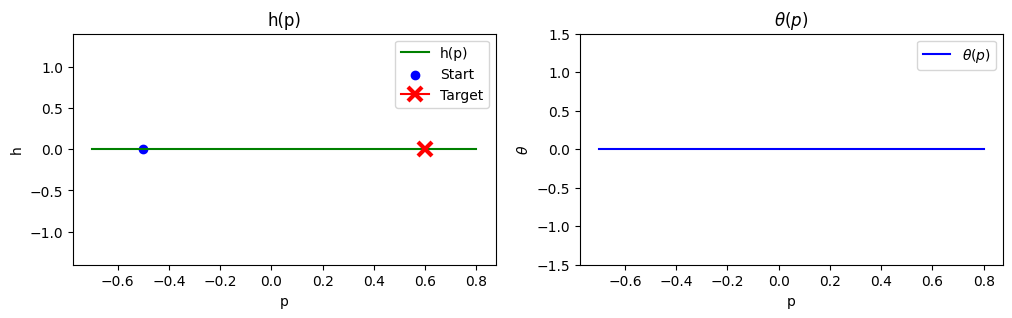

In [2]:
# Define profile of slope, the initial / target state
case = 1 # 1 or 2 or 3 or 4
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# Instantiate class 'Env'
# Arguments (without constraints): 
#   1) case: $n \in [1, 2, 3, 4]$, type: int
#   2) initial state: x_0 = [p_0, v_0], type: np.array
#   3) terminal state: x_T = [p_T, v_T], type: np.array
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
env.test_env() #  shape of slope (left side) and theta curve (right side) 

# Instantiate class 'Dynamics'
# Arguments: 
#   1) an object of class `Env`, type: Env  
dynamics = Dynamics(env)

---

### **Part (a): Implement the model predictive controller**

In this section, we will provide the implementation of the MPC controller and demonstrate how it can be applied to a stabilization task. We will also visualize the performance of the implemented MPC controller.



##### **Recall from LQR and iLQR:**

- For linear dynamical systems with a quadratic cost and no constraints, an LQR controller can be designed by solving the Algebraic Riccati Equation (ARE). 

- When the system dynamics are nonlinear and the cost is non-quadratic, the iLQR controller can be used by linearizing the dynamics (first-order Taylor expansion) and approximating the cost (second-order Taylor expansion), though it still cannot handle constraints. 

In this chapter, we introduce the Model Predictive Control (MPC) framework, which approximates the infinite-horizon optimal control problem with a finite and moving horizon formulation, thereby enabling constraint handling. This allows the MPC controller to better adapt to the design of controllers for complex control problems.

##### **Problem formulation of MPC:**

$$
J_k^*(\boldsymbol{x_k}) = \min_{u_{k|k}, \ldots, u_{k+N-1|k}} 
g_N\left( \boldsymbol{x_{k+N|k}} \right) + \sum_{i=0}^{N-1} g_i\left( \boldsymbol{x_{k+i|k}}, \boldsymbol{u_{k+i|k}} \right)
$$

subject to:

$$
\boldsymbol{x_{k+i+1|k}} = \boldsymbol{f} \left( \boldsymbol{x_{k+i|k}}, \boldsymbol{u_{k+i|k}} \right), \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{k+i|k}} \in \mathcal{X}, \quad \forall i \in \{0, \ldots, N\}
$$

$$
u_{k+i|k} \in \mathcal{U}, \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{k+N|k}} \in \mathcal{X}_f, 
$$

$$
\boldsymbol{x_{k|k}} = \boldsymbol{x_{k}},
$$

##### **Cost design in stabilization task:**

- Stage cost: The cost function consists of a tracking error term and an input penalty term. The tracking error term minimizes the deviation between the state trajectory and the target state, while the input penalty term prevents the controller from applying excessively large (even infinitely large) control inputs in pursuit of rapid convergence.

$$
g_i\left( \boldsymbol{x_{k+i|k}}, \boldsymbol{u_{k+i|k}} \right) = \left( \boldsymbol{x_{k+i|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q} \left( \boldsymbol{x_{k+i|k}} - \boldsymbol{x_T} \right) + u_{k+i|k} ^T \boldsymbol{R} u_{k+i|k}
$$

- Terminal cost: only the tracking error term

$$
g_N\left( \boldsymbol{x_{k+N|k}} \right) = \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)
$$


##### **Reformulation from original NLP problem to the QP form:**

For nonlinear programming (NLP) problems that employ a quadratic cost function, a common approach to get the solution is to reformulate the problem as a quadratic programming (QP) problem with nonlinear constraints and using specialized solvers. In this reformulation, the state and control variables at each shooting node are combined into a single augmented variable, and the cost function is then rewritten as a quadratic function of this new augmented variable. The reformulated states and costs can be expressed as follows:

- Intermediate shooting node (related to stage cost term $\forall i \in \{0, \ldots, N-1\}$): 

$$
\boldsymbol{z_{k+i|k}} = [\boldsymbol{x_{k+i|k}}^T, \boldsymbol{u_{k+i|k}}^T]^T,
$$

$$
\boldsymbol{z}_{ref} = [\boldsymbol{x_T}^T, \boldsymbol{0}^{1 \times m}]^T, 
$$

$$
g_i\left( \boldsymbol{x_{k+i|k}}, \boldsymbol{u_{k+i|k}} \right) = \left( \boldsymbol{z_{k+i|k}} - \boldsymbol{z}_{ref} \right)^T \begin{bmatrix} \boldsymbol{Q} & \boldsymbol{0}^{n \times m} \\ \boldsymbol{0}^{m \times n} & \boldsymbol{R} \end{bmatrix} \left( \boldsymbol{z_{k+i|k}} - \boldsymbol{z}_{ref} \right), 
$$

- Terminal shooting node (related to terminal cost term $i = N$):

$$
\boldsymbol{z_{k+N|k}} = \boldsymbol{x_{k+N|k}},
$$

$$
\boldsymbol{z}_{f,ref} = \boldsymbol{x_T}, 
$$

$$
g_N\left( \boldsymbol{x_{k+N|k}} \right) = \left( \boldsymbol{z_{k+N|k}} - \boldsymbol{z}_{f,ref} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{z_{k+N|k}} - \boldsymbol{z}_{f,ref} \right)
$$

##### **Step 1: define the setup function for MPC controller**  

In this step, we will implement the setup function `setup_external()`, which will be automatically called in the constructor of class `MPCController`. We use Acados as the solver for our MPC problem, which offers a rich Python interface for defining and solving optimization problems. The Python interface of Acados allows users to describe the dynamics, cost, and constraints symbolically. It then handles code generation, compilation, and solver setup internally, enabling fast and efficient online optimization. The implementation will follow three key steps:

1\) Instantiate the class `AcadosModel`, specify the state / input vector and the symbolic system dynamcis;  
    Hint: you may get the state / input vectors and the system dynamcis from class `Dynamics` 

2\) Instantiate the class `AcadosOcp`, specify the model and the optimiation problem (incl. solver configurations, costs, constraints, etc.);  
    Hint 1: the standard formulation of an optimal control problem in Acados please refer to the attachment [problem_formulation_ocp_acados.pdf](./problem_formulation_ocp_acados.pdf)    
    Hint 2: the python interfaces provided by Acados for solver configuration please refer to this [website](https://docs.acados.org/python_interface/index.html)  


3\) Instantiate the class `AcadosOcpSolver` with the object of class `AcadosOcp`; 

In [3]:
def setup_external(self) -> None:

    """
    Define the MPC optimization problem using Acados.
    """
    
    ## Model
    # Set up Acados model
    model = AcadosModel()
    model.name = self.name

    # Define model: x_dot = f(x, u)
    model.x = self.dynamics.states
    model.u = self.dynamics.inputs
    model.f_expl_expr = ca.vertcat(self.dynamics.dynamics_function(self.dynamics.states, self.dynamics.inputs))
    model.f_impl_expr = None # no needed, we already have the explicit model


    ## Optimal control problem
    # Set up Acados OCP
    ocp = AcadosOcp()
    ocp.model = model # link to the model (class: AcadosModel)
    ocp.dims.N = self.N  # prediction horizon
    ocp.solver_options.tf = self.N * self.dt  # total prediction time
    ocp.solver_options.qp_solver = "FULL_CONDENSING_HPIPM" # Partially condensing interior-point method
    ocp.solver_options.integrator_type = "ERK" # explicit Runge-Kutta
    ocp.solver_options.nlp_solver_type = "SQP" # sequential quadratic programming

    # Set up other hyperparameters in SQP solving
    ocp.solver_options.nlp_solver_max_iter = 100
    ocp.solver_options.nlp_solver_tol_stat = 1E-6
    ocp.solver_options.nlp_solver_tol_eq = 1E-6
    ocp.solver_options.nlp_solver_tol_ineq = 1E-6
    ocp.solver_options.nlp_solver_tol_comp = 1E-6
    
    # For debugging
    #ocp.solver_options.print_level = 2

    # Set up cost function
    ocp.cost.cost_type = "LINEAR_LS"
    ocp.cost.cost_type_e = "LINEAR_LS"
    ocp.cost.W = np.block([
        [self.Q, np.zeros((self.dim_states, self.dim_inputs))],
        [np.zeros((self.dim_inputs, self.dim_states)), self.R],
    ])
    ocp.cost.W_e = self.Qf

    # Set up mapping from QP to OCP
    # Define output matrix for non-terminal state
    ocp.cost.Vx = np.block([
        [np.eye(self.dim_states)],
        [np.zeros((self.dim_inputs, self.dim_states))]
    ])
    # Define breakthrough matrix for non-terminal state
    ocp.cost.Vu = np.block([
        [np.zeros((self.dim_states, self.dim_inputs))],
        [np.eye(self.dim_inputs)]
    ])
    # Define output matrix for terminal state
    ocp.cost.Vx_e = np.eye(self.dim_states)

    # Initialize reference of task (stabilization)
    ocp.cost.yref = np.zeros(self.dim_states + self.dim_inputs) 
    ocp.cost.yref_e = np.zeros(self.dim_states) 

    # Define constraints
    ocp.constraints.x0 = self.init_state  # Initial state

    # State constraints
    ocp.constraints.idxbx = np.arange(self.dim_states)
    ocp.constraints.idxbx_e = np.arange(self.dim_states)
    if self.env.state_lbs is None and self.env.state_ubs is None:
        ocp.constraints.lbx_0 = np.full(self.dim_states, -1e6)
        ocp.constraints.ubx_0 = np.full(self.dim_states, 1e6)
        ocp.constraints.lbx = np.full(self.dim_states, -1e6)
        ocp.constraints.ubx = np.full(self.dim_states, 1e6)
        ocp.constraints.lbx_e = np.full(self.dim_states, -1e6)
        ocp.constraints.ubx_e = np.full(self.dim_states, 1e6)
    elif self.env.state_lbs is not None and self.env.state_ubs is None:
        ocp.constraints.lbx_0 = np.array(self.env.state_lbs)
        ocp.constraints.ubx_0 = np.full(self.dim_states, 1e6)
        ocp.constraints.lbx = np.array(self.env.state_lbs)
        ocp.constraints.ubx = np.full(self.dim_states, 1e6)
        ocp.constraints.lbx_e = np.array(self.env.state_lbs)
        ocp.constraints.ubx_e = np.full(self.dim_states, 1e6)
    elif self.env.state_lbs is None and self.env.state_ubs is not None:
        ocp.constraints.lbx_0 = np.full(self.dim_states, -1e6)
        ocp.constraints.ubx_0 = np.array(self.env.state_ubs)
        ocp.constraints.lbx = np.full(self.dim_states, -1e6)
        ocp.constraints.ubx = np.array(self.env.state_ubs)
        ocp.constraints.lbx_e = np.full(self.dim_states, -1e6)
        ocp.constraints.ubx_e = np.array(self.env.state_ubs)
    else:
        ocp.constraints.lbx_0 = np.array(self.env.state_lbs)
        ocp.constraints.ubx_0 = np.array(self.env.state_ubs)
        ocp.constraints.lbx = np.array(self.env.state_lbs)
        ocp.constraints.ubx = np.array(self.env.state_ubs)
        ocp.constraints.lbx_e = np.array(self.env.state_lbs)
        ocp.constraints.ubx_e = np.array(self.env.state_ubs)
    
    # Input constraints
    ocp.constraints.idxbu = np.arange(self.dim_inputs)
    if self.env.input_lbs is None and self.env.input_ubs is None:
        ocp.constraints.lbu = np.full(self.dim_inputs, -1e6)
        ocp.constraints.ubu = np.full(self.dim_inputs, 1e6)
    elif self.env.input_lbs is not None and self.env.input_ubs is None:
        ocp.constraints.lbu = np.array(self.env.input_lbs)
        ocp.constraints.ubu = np.full(self.dim_inputs, 1e6)
    elif self.env.input_lbs is None and self.env.input_ubs is not None:
        ocp.constraints.lbu = np.full(self.dim_inputs, -1e6)
        ocp.constraints.ubu = np.array(self.env.input_ubs)
    else:
        ocp.constraints.lbu = np.array(self.env.input_lbs)
        ocp.constraints.ubu = np.array(self.env.input_ubs)


    ## Ocp Solver
    # Set up Acados solver
    self.ocp = ocp
    self.solver = AcadosOcpSolver(ocp, json_file=f"{model.name}.json")

    if self.verbose:
        print("MPC setup with Acados completed.")


##### **Step 2: define the loop function to call the API of Acados in each control cycle**  

After defining the optimization problem using Acados' Python interface and generating the corresponding solver package, we need to assign values to variables and compute the control output in each control cycle. This process will be encapsulated in a control loop function `compute_action_external()`, which is called at every time step. In each cycle, you need to:

1\) Assign value for initial state and tracking reference via interface `set()`;  

2\) Solve OCP problem via calling interface `solve()`;  

3\) Get the first input command via interface `get()`;  

In [4]:
def compute_action_external(self, current_state: np.ndarray, current_time) -> np.ndarray:
    """
    Solve the MPC problem and compute the optimal control action.

    Args:
    - current_state: The current state of the system.
    - current_time: The current time (not used in this time-invariant case).

    Returns:
    - Optimal control action.
    """

    print(f"Current state: {current_state}")
    print(f"Target state: {self.target_state}")


    # Update initial state in the solver
    self.solver.set(0, "lbx", current_state)
    self.solver.set(0, "ubx", current_state)

    # Update reference trajectory for all prediction steps
    state_ref = self.target_state
    input_ref = np.zeros(self.dim_inputs)
    for i in range(self.N):
        self.solver.set(i, "yref", np.concatenate((state_ref, input_ref)))
    self.solver.set(self.N, "yref", state_ref) # set reference valur for y_N seperately (different shape)

    # Solve the MPC problem
    status = self.solver.solve()
    #if status != 0:
    #    raise ValueError(f"Acados solver failed with status {status}")

    # Extract the first control action
    u_optimal = self.solver.get(0, "u")

    # Extract the predictions
    x_pred = np.zeros((self.N + 1, self.dim_states))
    u_pred = np.zeros((self.N, self.dim_inputs))
    for i in range(self.N + 1):
        x_pred[i, :] = self.solver.get(i, "x")
        if i < self.N:
            u_pred[i, :] = self.solver.get(i, "u")

    if self.verbose:
        print(f"Optimal control action: {u_optimal}")
        #print(f"x_pred: {x_pred}")
        #print(f"u_pred: {u_pred}")

    return u_optimal, x_pred, u_pred

##### **Step 3: Bind the defined setup function and control loop to the class "MPCController", and run the simulation to see the performance of controller**  

1\) Bind the defined setup function `setup_external()` and control loop function `compute_action_external()` to class `MPCController`;

2\) Specify the arguments and instantiate the controller class `MPCController` as `MPC_0`; 

- Parameters in the controller design:  

    i) weight for state $\bm{Q} = \text{diag}([1, 1])$ (requirement: symmetric, positive semi-definite matrix)  

    ii) weight for input $\bm{R} = [0.1]$ (requirement: symmetric, positive definite matrix)  
    
    iii) control frequency $f = 20$

    iv) horizon $N = 20$

3\) Instantiate the class `Simulator` and call function `run_simulation()` to generate the simulated state- and input-trajectory;

4\) Instantiate the class `Visualizor`, call function `display_final_results()` and `display_animation()` to show the simulations;


Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_0.so
rm -f acados_solver_MPC_0.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC_0.o acados_solver_MPC_0.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_0_model/MPC_0_expl_ode_fun.o MPC_0_model/MPC_0_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/

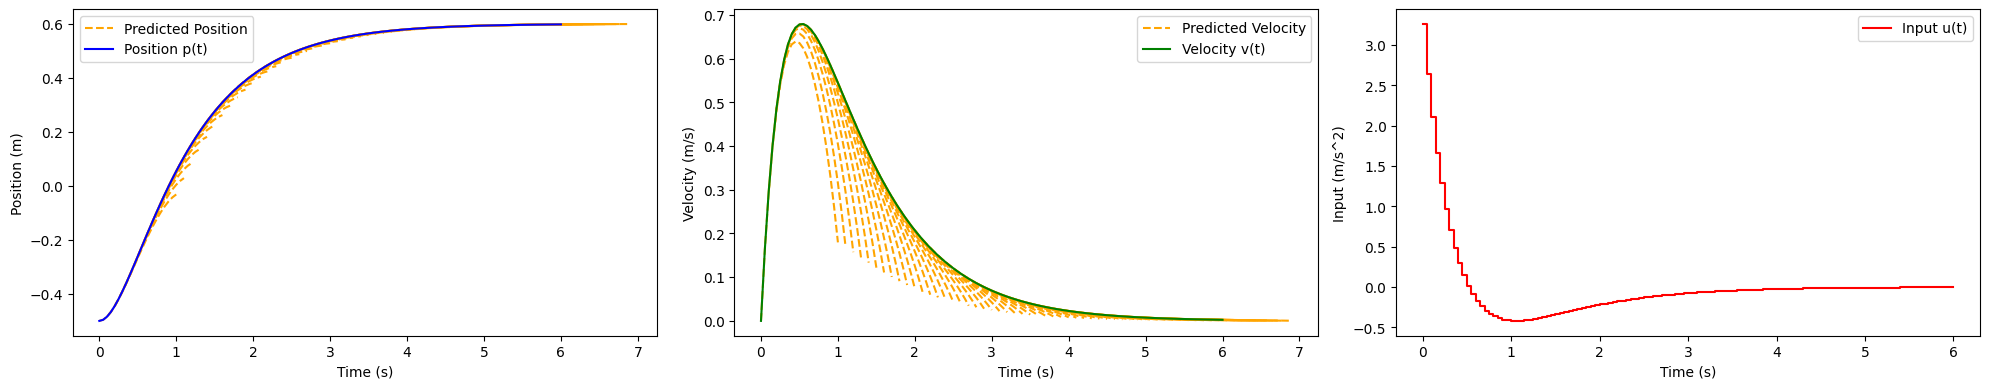

In [5]:
# Bind the defined MPC controller setup function to the corresponding class, will be automatically called by constructor
MPCController.setup = setup_external
MPCController.compute_action = compute_action_external

# Define weight matrix in stage and terminal cost and the horizon for MPC 
Q = np.diag([1, 1])
R = np.array([[0.1]])
Qf = Q
N = 20

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation

# Instantiate the MPC controller class
# Arguments: 
#   1) an object of class `Env` (to deliver infos about initial state, constraints, etc.), type: Env  
#   2) an object of class `Dynamics` (to deliver infos about symbolic system dynamics), type: Dynamics  
#   3) weight matrices in cost functions: i) `Q`: weight metrix of state, type: np.array  
#                                         ii) `R`: weight metrix of input, type: np.array  
#                                         iii) `Q_f`: weight metrix of state in terminal cost, type: np.array  
#   4) freq: control frequency $f$ , type: int  
#   5) N: horizon in MPC , type: int  
#   6) name: the name of current controller displayed in plots, type: string
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name="MPC_0")

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_plots()
#visualizer_mpc.display_animation()

---

### **Part (b): Compatibility with state and input constraints**

In the previous two chapters, we introduced the LQR and iLQR controllers, whose control laws are given in explicit form and thus are not compatible with constraint definitions. In contrast, MPC does not compute an explicit control law by eliminating similiar terms. Instead, at each time step, it formulates a (sequential) quadratic programming problem over all state- and input-variables. This allows arbitrary constraints to be directly incorporated into the optimization. As a result, the control variables (states and inputs) obtained from MPC inherently satisfy the constraints, making the resulting optimization problem better aligned with the physical problem it represents.


In this section, we will show this characteristics by introducing the state and input constraint into the optimization problem defined in **Part (B)**. More detailed, the constraints are:

- State constraints: $ \quad p \in [-2.0, 2.0], \quad v \in [-1.0, 1.0],$  

- Input constraints: $ \quad a \in [-0.25, 0.25],$  

By introducing these constraints, we simulate the system's response and make a contrast with the controller defined in **Part (B)** (`MPC_0`).

In [6]:
# Define the physical boundary condition
state_lbs = np.array([-2.0, -1.0])
state_ubs = np.array([2.0, 1.0])
input_lbs = -0.25
input_ubs = 0.25


Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_constr.so
rm -f acados_solver_MPC_constr.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC_constr.o acados_solver_MPC_constr.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_constr_model/MPC_constr_expl_ode_fun.o MPC_constr_model/MPC_constr_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include

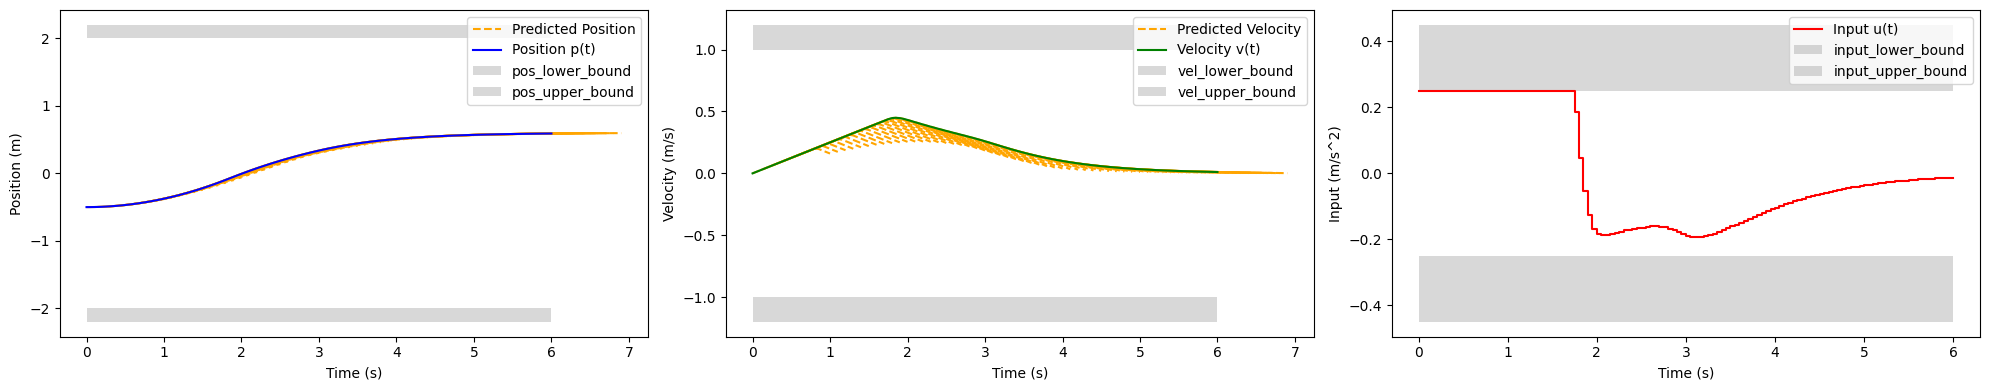

In [7]:
# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
env_constr = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
#env.test_env()

# Instantiate class 'Dynamics'
dynamics_constr = Dynamics(env_constr)

# Instantiate the iLQR controller class (controller name must be different from the rest controllers)
controller_mpc_constr = MPCController(env_constr, dynamics_constr, Q, R, Qf, freq, N, name="MPC_constr")

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc_constr = Simulator(dynamics_constr, controller_mpc_constr, env_constr, 1/freq, t_terminal)
simulator_mpc_constr.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc_constr = Visualizer(simulator_mpc_constr)
visualizer_mpc_constr.display_plots()
#visualizer_mpc_constr.display_animation()


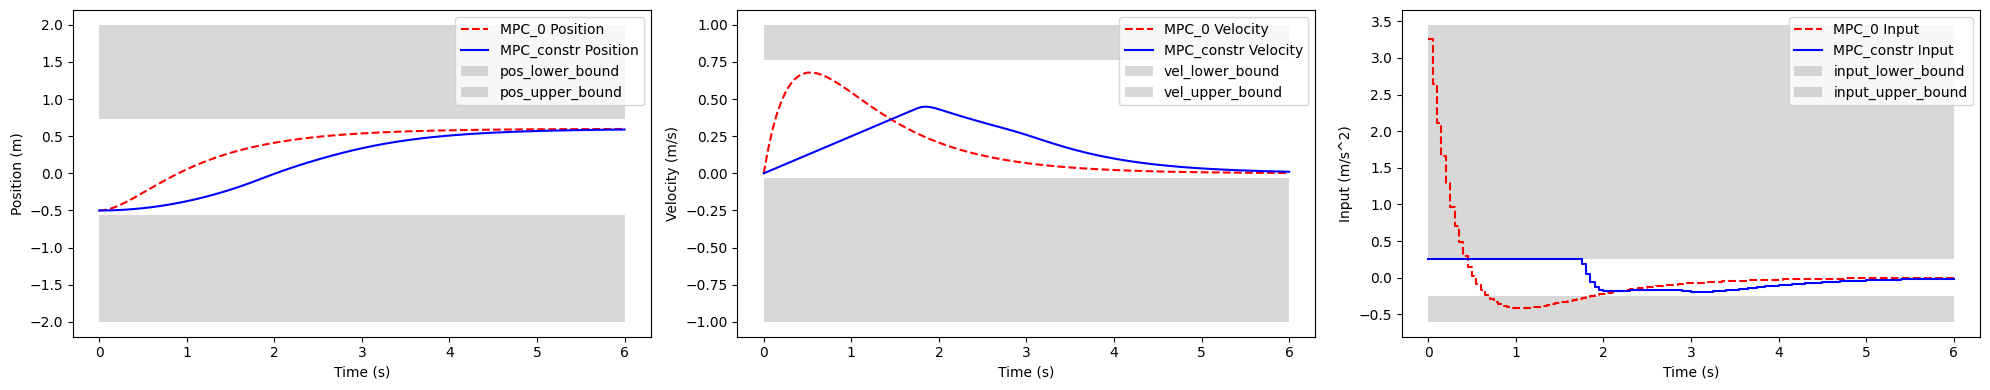

In [8]:
# Contrast with the unconstrained MPC
visualizer_mpc_constr.display_contrast_plots(simulator_mpc)

#### **Results Analysis:**

By examining the input trajectories (accelerations) of both cases, we observe that the original MPC controller (`MPC_0`) generates control commands that violate the input constraints during the initial phase. If such commands are directly applied to the real system, they may cause a saturation between the control input and the real system response, potentially leading to unexpected behavior. In contrast, the constraint-aware MPC controller (`MPC_constr`) consistently produces control inputs that satisfy the constraints, demonstraiting the constraints-handling capability of the MPC algorithm.


---


### **Part (c): Influence of Hyperparameter Selection on MPC Performance**

The main hyperparameters in MPC include the prediction horizon $N$, sampling frequency $f$, and weighting matrices $\boldsymbol{Q}$, $\boldsymbol{R}$, and $\boldsymbol{Q}_f$, etc. The influence of these hyperparameters as listed as follows:

  1) Prediction horizon $N$: A shorter prediction horizon reduces computation time per cycle, improving real-time compatibility, but may result in suboptimal or overly reactive behavior due to the limited foresight. A longer horizon allows the controller to anticipate future states more effectively, often producing smoother or more optimal trajectories, but at the cost of increased computational load and longer cycle time;

  2) Sampling frequency $f$: A higher sampling frequency (i.e., smaller sampling time) enables faster control updates and can predict the behavior of the high-frequency system dynamics more accurately, leading to better control performance, especially in fast systems. However, it increases the computational burden due to more frequent update. Conversely, a lower sampling frequency reduces computational demand but may degrade performance or even destabilize the system if critical dynamics are missed;

  3) Weighting matrices $\boldsymbol{Q}$, $\boldsymbol{R}$, and $\boldsymbol{Q}_f$: These matrices define the relative importance of state tracking versus control effort in the cost function. $\boldsymbol{Q}$ penalizes deviation from desired states, $\boldsymbol{R}$ penalizes excessive or aggressive control inputs, and $\boldsymbol{Q}_f$ defines the terminal state penalty, encouraging the system to reach the final desired state smoothly. As in LQR, tuning these matrices allows you to balance tracking accuracy and control smoothness or energy efficiency.



##### **Influence of Prediction Horizon $N$ on MPC Performance**

As discussed in Chapter 2, the impact of the weight matrices on the performance of MPC has been well-established. The prediction horizon $N$, as another important and unique hyperparameter in the MPC algorithm, similarly plays a crucial role. However, its precise effect on performance is yet to be fully understood. Therefore, in this section, we will focus on exploring the impact of the horizon length on the performance of the MPC algorithm.

To better highlight the impact of the prediction horizon, we specifically designed the following task setup:

- Environment: case 4, varying slope, underactuated case (shape as shown in the output of the first block)

- Initial/target state: $ \quad \boldsymbol{x}_s = [-0.5, 0]^T, \quad \boldsymbol{x}_T = [0.6, 0]^T,$  

- State constraints: $ \quad p \in [-2.0, 2.0], \quad v \in [-4.0, 4.0],$  

- Input constraints: $ \quad a \in [-5.0, 5.0],$  

The reccomanded hyperparameter are:

- Weight for state $\bm{Q} = \text{diag}([1, 1])$ (requirement: symmetric, positive semi-definite matrix)  

- Weight for input $\bm{R} = [0.1]$ (requirement: symmetric, positive definite matrix)  
    
- Control frequency $f = 20$

- Horizon $N = 20 / 60 / 100$ **(Control Group)**

Based on the above task and controller setup, we instantiate various configurations and perform simulations. Please vary prediction horizon with values of 20, 60, and 100, respectively, and observe the corresponding simulation results.

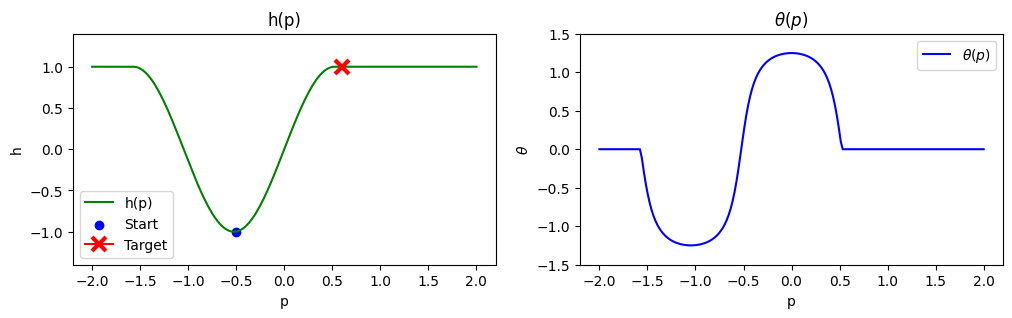

In [9]:
# Define the case index for the slope profile
case = 4 

# Define the initial and target state
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# Define the physical boundary condition
state_lbs = np.array([-2.0, -4.0])
state_ubs = np.array([2.0, 4.0])
input_lbs = -5.0
input_ubs = 5.0

# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
#env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
env.test_env()

# Instantiate class 'Dynamics'
dynamics = Dynamics(env)


In [ ]:
# Define weight matrix in stage and terminal cost
Q = np.diag([1, 1])
R = np.array([[0.1]])
Qf = Q

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_20.so
rm -f acados_solver_MPC_20.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC_20.o acados_solver_MPC_20.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_20_model/MPC_20_expl_ode_fun.o MPC_20_model/MPC_20_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/

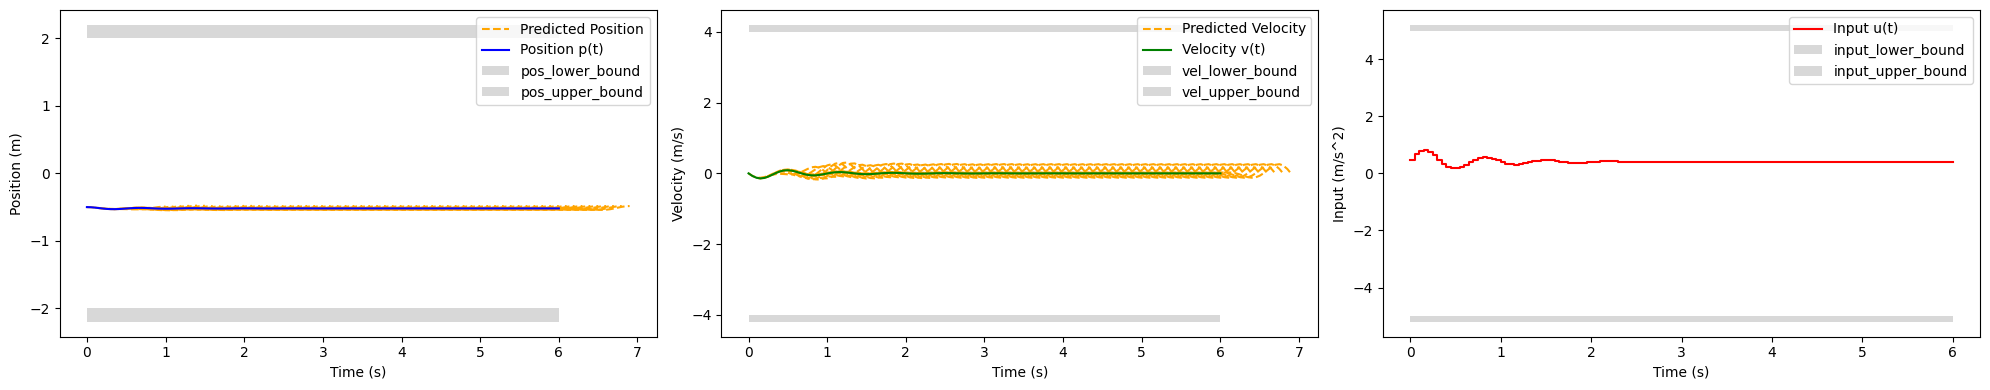

In [ ]:
N = 20

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation

# Instantiate the iLQR controller class (controller name must be different from the rest controllers)
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name="MPC_20")

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_plots()
#visualizer_mpc.display_animation()

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_60.so
rm -f acados_solver_MPC_60.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC_60.o acados_solver_MPC_60.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_60_model/MPC_60_expl_ode_fun.o MPC_60_model/MPC_60_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/

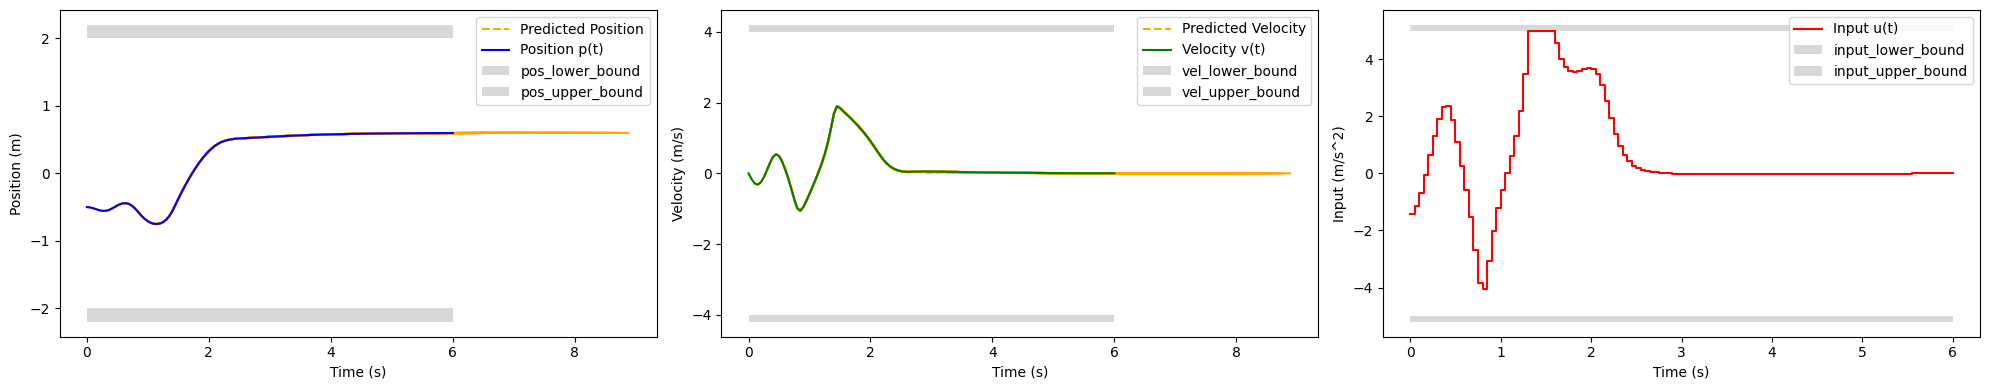

In [11]:
N = 60

# Instantiate the iLQR controller class (controller name must be different from the rest controllers)
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name="MPC_60")

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_plots()
#visualizer_mpc.display_animation()

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_100.so
rm -f acados_solver_MPC_100.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC_100.o acados_solver_MPC_100.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_100_model/MPC_100_expl_ode_fun.o MPC_100_model/MPC_100_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng

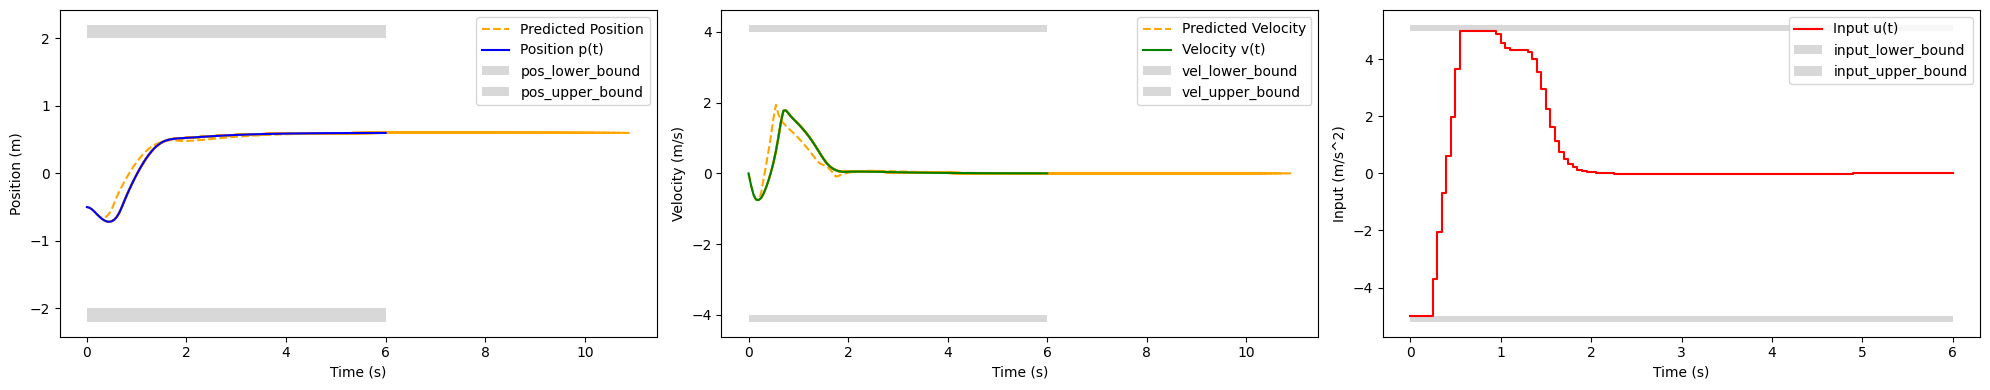

In [12]:
N = 100

# Instantiate the iLQR controller class (controller name must be different from the rest controllers)
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name="MPC_100")

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_plots()
#visualizer_mpc.display_animation()

##### **Results Analysis: system response under different horizon lengths**

For the defined task, while keeping the value of all other hyperparameters fixed, we vary the value of $N$ to represent short, medium, and long horizon cases. From the experimental results, the following trends can be observed:

1. **Short prediction horizon** ($N = 20$):  
   - Under this condition, the car is unable to reach the target position. Instead, after a brief oscillation, it comes to rest at the bottom of the valley;  
   - This outcome arises because, within the current prediction horizon (20 steps at 20 Hz, i.e., 1 second), the presence of input constraints makes it impossible to reach the goal even under a bang-bang control strategy. Consequently, the MPC prioritizes minimizing the penalty term on input, leading to a zero-input solution."

2. **Middle prediction horizon** ($N = 60$):  
   - In this scenario, the car begins by moving backward, undergoes cycles of back-and-forth motion with increasing amplitude, and then propels itself toward the top, successfully reaching the target location;
   - This behavior arises because, in the underactuated case, the car is unable to generate sufficient input to reach the top in a single ascent. However, when the prediction horizon is sufficiently long, the system can perform periodic back-and-forth motions to accumulate additional momentum. Once enough kinetic energy has been gained, the car is able to propel itself over the peak.

3. **Long prediction horizon** ($N = 100$):  
   - In this case, compared to the middle prediction horizon scenario, the car requires fewer momentum accumulation cycles to reach the top;
   - This is because, compared to the case with N=60, the prediction horizon with N=100 covers a longer time interval. Specifically, N=60 corresponds to a prediction window of 3s (60 steps at 20 Hz), while the transient behavior in this case lasts approximately 4 seconds, as observed from the simulation results. As a result, at the start of the optimization, the MPC cannot foresee the car reaching the top, and thus chooses a strategy involving more cycles of momentum accumulation. 
   - On the other hand, with N=100, the prediction horizon spans 5 seconds. Therefore, the prediction horizon fully encompasses the transient behavior, allowing the MPC to effectively optimize over approximately the whole timeline. As a result, the computed control sequence can be regarded as a near-optimal policy.

##### **Main Conclusion:**

In summary, the length of the prediction horizon significantly influences the system's ability to generate effective control strategies. A short horizon limits the controller's foresight, leading to suboptimal or even ineffective behavior. In contrast, a sufficiently long horizon allows the MPC to anticipate the full transient dynamics and compute near-optimal control actions. Therefore, selecting an appropriate horizon length is critical for achieving desired performance in MPC design.

